----
INTRUSION DETECTION SYSTEM USING MULTILEVEL RANDOM FOREST MODEL & FUZZY INFERENCE SYSTEM
----

In [1]:
#IMPORTING MODELS


#For Data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler

#For Feature selection
from sklearn.feature_selection import mutual_info_classif,SelectKBest

#For MultiLevel Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
from imblearn.over_sampling import SMOTE

#For Fuzzy-Inference System
import skfuzzy as fuzz
import numpy as np

#For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Confusion Matrix
from sklearn.metrics import confusion_matrix


----
DATA PREPARATION

In [2]:
#Loading Data
data=pd.read_csv('C:/Users/subha/OneDrive/Desktop/FINAL YEAR PROJECT/NSL-KDD.csv')

#Encode categorical features
categorical_cols=['protocol_type','service','flag']
for col in categorical_cols:
  data[col]=LabelEncoder().fit_transform(data[col])


#Separate features and target
X=data.drop('labels',axis=1)
Y=data['labels']

#Scale the features
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

#Splitting the data into test & train sets
X_train,X_test,Y_train,Y_test=train_test_split(X_scaled,Y,test_size=0.3,random_state=42)

In [3]:
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(15780, 41) (6764, 41) (15780,) (6764,)


----
FEATURE SELECTION


In [4]:
#Correlation-Based Feature Selection
k=20
selector=SelectKBest(score_func=mutual_info_classif,k=k)
X_train_selected=selector.fit_transform(X_train,Y_train)
X_test_selected=selector.transform(X_test)
selected_features=X.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['service', 'flag', 'src_bytes', 'dst_bytes', 'logged_in', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate',
       'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')


----
TRAINING A MULTI-LEVEL RANDOM FOREST

In [5]:
#Level-1 Random Forest
rf_level1=RandomForestClassifier(n_estimators=100,random_state=42)
rf_level1.fit(X_train_selected,Y_train)

#Predictand pass to the next level
y_pred_level1=rf_level1.predict(X_train_selected)

#Level-2 Random Forest(refinement)
rf_level2=RandomForestClassifier(n_estimators=50,random_state=42)
rf_level2.fit(X_train_selected,y_pred_level1)


#Final Predictions
y_pred_final=rf_level2.predict(X_test_selected)

#Evaluation
print("Accuracy:",accuracy_score(Y_test,y_pred_final))
print(classification_report(Y_test,y_pred_final))

Accuracy: 0.9853636901241869
                 precision    recall  f1-score   support

        apache2       1.00      0.98      0.99        59
           back       1.00      1.00      1.00        48
buffer_overflow       0.00      0.00      0.00         7
   guess_passwd       1.00      0.98      0.99       133
     httptunnel       0.92      1.00      0.96        12
           imap       0.00      0.00      0.00         1
        ipsweep       0.99      0.95      0.97       120
           land       0.00      0.00      0.00         2
     loadmodule       0.00      0.00      0.00         1
       mailbomb       1.00      1.00      1.00        30
          mscan       1.00      0.95      0.97        82
       multihop       0.00      0.00      0.00         2
          named       0.00      0.00      0.00         1
        neptune       1.00      1.00      1.00      2024
           nmap       0.93      0.97      0.95        58
         normal       0.98      0.99      0.99      3378
 

C:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

----
FUZZY INFERENCE SYSTEM (FIS)

In [6]:
#define fuzzy variables
severity=np.arange(0,101,1)
low=fuzz.trimf(severity,[0,0,50])
medium=fuzz.trimf(severity,[30,50,70])
high=fuzz.trimf(severity,[60,100,100])

#Define fuzzy inference rules
def assess_severity(prob):
    if prob<0.5:
        return "Low"
    elif 0.5<=prob<0.8:
        return "Medium"
    else:
        return "High"


#Apply FIS to refine classification
rf_probs=rf_level2.predict_proba(X_test_selected)[:,1]
severity_assessments=[assess_severity(prob) for prob in rf_probs]

print("Severity Assessments Example:",severity_assessments[:10])

Severity Assessments Example: ['Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low']


----
VISUALIZATION

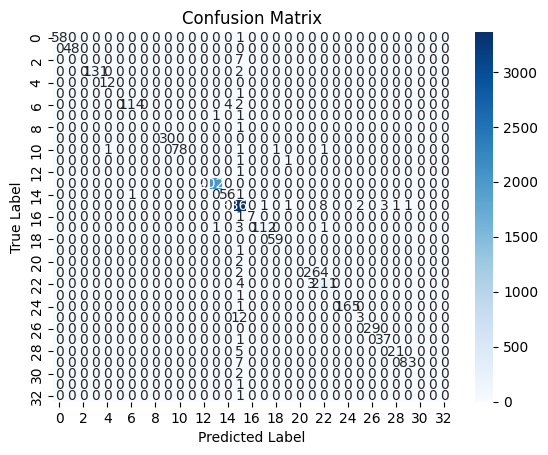

In [7]:
#Confusion Matrix
cm=confusion_matrix(Y_test,y_pred_final)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()